Install most current PyMC3

In [1]:
!pip install -U git+https://github.com/pymc-devs/pymc3.git

  Cloning https://github.com/pymc-devs/pymc3.git to /private/var/folders/_v/3r_8fkqs5_qgjp6zp4j6zxnr0000gp/T/pip-req-build-30_0oohv
    100% |████████████████████████████████| 2.8MB 1.7MB/s ta 0:00:011
  Running setup.py bdist_wheel for pymc3 ... done
  Stored in directory: /private/var/folders/_v/3r_8fkqs5_qgjp6zp4j6zxnr0000gp/T/pip-ephem-wheel-cache-_dkbg42g/wheels/00/66/95/56ef7fc0279ccee186eb72eb3360f5978767d069c005eb64bd
  Running setup.py bdist_wheel for theano ... done
  Stored in directory: /Users/michael/Library/Caches/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built pymc3 theano
  Found existing installation: Theano 1.0.2
    Uninstalling Theano-1.0.2:
      Successfully uninstalled Theano-1.0.2
  Found existing installation: pymc3 3.4.1
    Uninstalling pymc3-3.4.1:
      Successfully uninstalled pymc3-3.4.1
You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrad

In [2]:
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
import pandas
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import scipy as sp
import theano.tensor as t

In [3]:
DATA_DIR = '../../Data/'

In [4]:
#read in dataset created in imputation notebook
data = pd.read_csv(DATA_DIR + "CleanedForRegression.csv")
#recode sex to female for indicator of being female in keepign with other variable coding
data['female'] = data['sex'] - 1
#drop data that is irrelevant or duplicated in other columms (ie just keep 1 indicator of age etc)
data = data.drop(['Unnamed: 0', 'incdate', 'agemth', 'incdate', 'incyear', 'incmonth', 'ageyrs', 'ageym', 'dimain' , 'dimainsp','sex'], axis = 1)


In [5]:
import theano.tensor as tt
softmax = tt.nnet.softmax

In [6]:
y = data['diag'].values

In [7]:
#Imputation func from Fonnesbeck Enrollment Model.ipynb from infant_hearing_intervention
def fillna(x, value):
    x_masked = np.ma.masked_invalid(x)
    np.ma.set_fill_value(x_masked, value)
    return x_masked

In [8]:
variable_cols = ['temp', 'glasgtot', 'female', 'rdtresult', 'vacmen', 'incphoto', 'incirrit', 
                'sbp', 'muac', 'incfont', 'incneck', 'incseiza', 'incseizh', 'age']

data[variable_cols].isnull().sum()

temp           0
glasgtot      53
female         0
rdtresult     10
vacmen        77
incphoto     204
incirrit      17
sbp           79
muac           6
incfont      205
incneck        7
incseiza       1
incseizh       3
age            0
dtype: int64

In [9]:
data[variable_cols].head()

,temp,glasgtot,female,rdtresult,vacmen,incphoto,incirrit,sbp,muac,incfont,incneck,incseiza,incseizh,age
0,38.6,15.0,0,1.0,0.0,0.0,1.0,137.0,16.0,NaN,0.0,0.0,0.0,36.0
1,38.4,NaN,0,1.0,NaN,NaN,0.0,99.0,13.0,NaN,0.0,1.0,0.0,30.0
2,35.9,11.0,1,1.0,1.0,0.0,0.0,81.0,16.0,NaN,0.0,0.0,1.0,41.0
3,37.0,NaN,0,0.0,0.0,0.0,0.0,106.0,16.0,NaN,0.0,0.0,1.0,23.0
4,38.1,8.0,0,1.0,0.0,0.0,0.0,NaN,15.0,NaN,0.0,0.0,1.0,51.0


In [10]:
(temp, glasgtot, female, rdtresult, 
 vacmen, incphoto, incirrit, 
 sbp, muac, incfont, incneck, 
 incseiza, incseizh, age) = data.fillna({'incseiza':0}).assign(glasgtot=data.glasgtot - 3,
                                                              sbp=data.sbp - data.sbp.mean(),
                                                              muac=data.muac - data.muac.mean(),
                                                              age=data.age - data.age.mean(),
                                                              temp=data.temp - data.temp.min())[variable_cols].values.T

In [508]:
with pm.Model() as logistic_model:
    
    # Impute continuous variables
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_invalid(muac))
    else:
        x_muac = muac
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_invalid(rdtresult))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_invalid(vacmen))
    else:
        x_vacmen = vacmen          
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_invalid(incphoto))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_invalid(incirrit))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_invalid(incfont))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_invalid(incneck))
    else:
        x_incneck = incneck
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_invalid(incseizh))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult, x_glasgtot, x_vacmen, female, x_incphoto, x_incirrit,
         x_muac, x_incfont, x_incneck, x_incseizh]

    N, K = len(X), len(set(y))
    
    μ = pm.Normal('μ', 0, sd=5, shape=K)
    effects = pm.Normal('effects', mu=0, sd=5, shape=(N, K))
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis=1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Categorical('Y_obs', p=p, observed=y)

In [509]:
with logistic_model:
    trace = pm.sample(8000, tune=8000, cores=2)


INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [effects, μ, p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac]
>CategoricalGibbsMetropolis: [x_glasgtot_missing]
>BinaryGibbsMetropolis: [x_rdtresult_missing, x_vacmen_missing, x_incphoto_missing, x_incirrit_missing, x_incfont_missing, x_incneck_missing, x_incseizh_missing]
Sampling 2 chains: 100%|██████████| 32000/32000 [8:54:03<00:00,  1.52s/draws]     
The number of effective samples is smaller than 25% for some parameters.


In [510]:
_varnames = [varname.name for varname in logistic_model.free_RVs if (varname.name.startswith('mu_')
                                                                     or varname.name.startswith('p_'))]

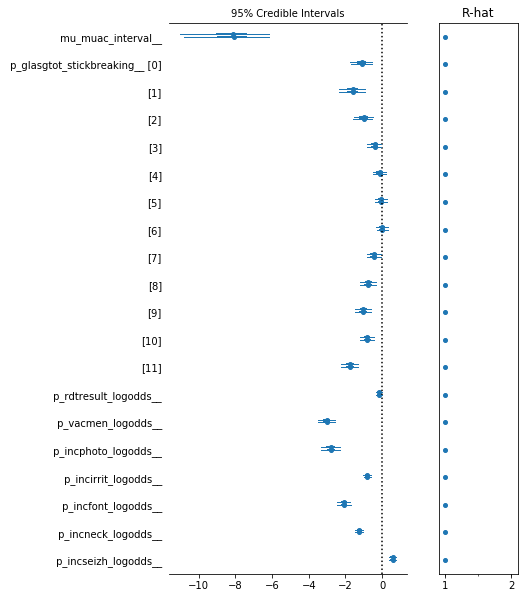

In [511]:
pm.forestplot(trace, varnames=_varnames)

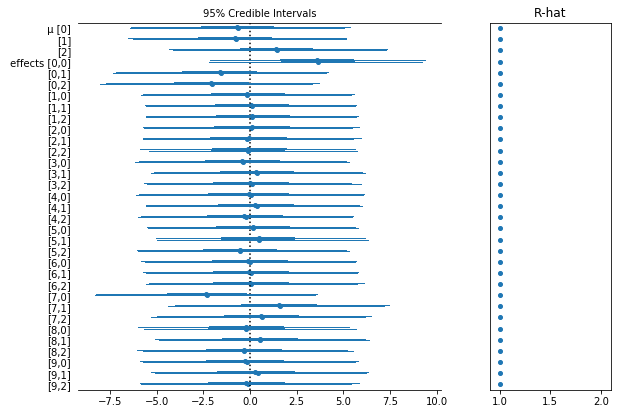

In [512]:
plt.figure(figsize=(10,6))
pm.forestplot(trace, varnames = ["μ", "effects"]);


In [513]:
import pickle 
with open('trace10k10k13.pkl', 'wb') as buff:
    pickle.dump(trace, buff)

In [27]:
import pickle
#this loads a saved trace file
#with open('trace10k10ktd13.pkl', 'rb') as buff:
#    external_trace = pickle.load(buff)

In [6]:
#pm.energyplot(trace)

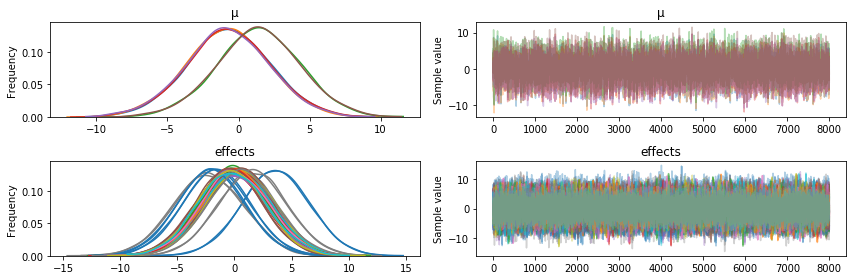

In [515]:
pm.traceplot(trace, varnames = ["μ", "effects"]);

In [142]:
#pm.forestplot(trace, varnames=['effects'])

In [3]:
#pm.plots.densityplot(trace)

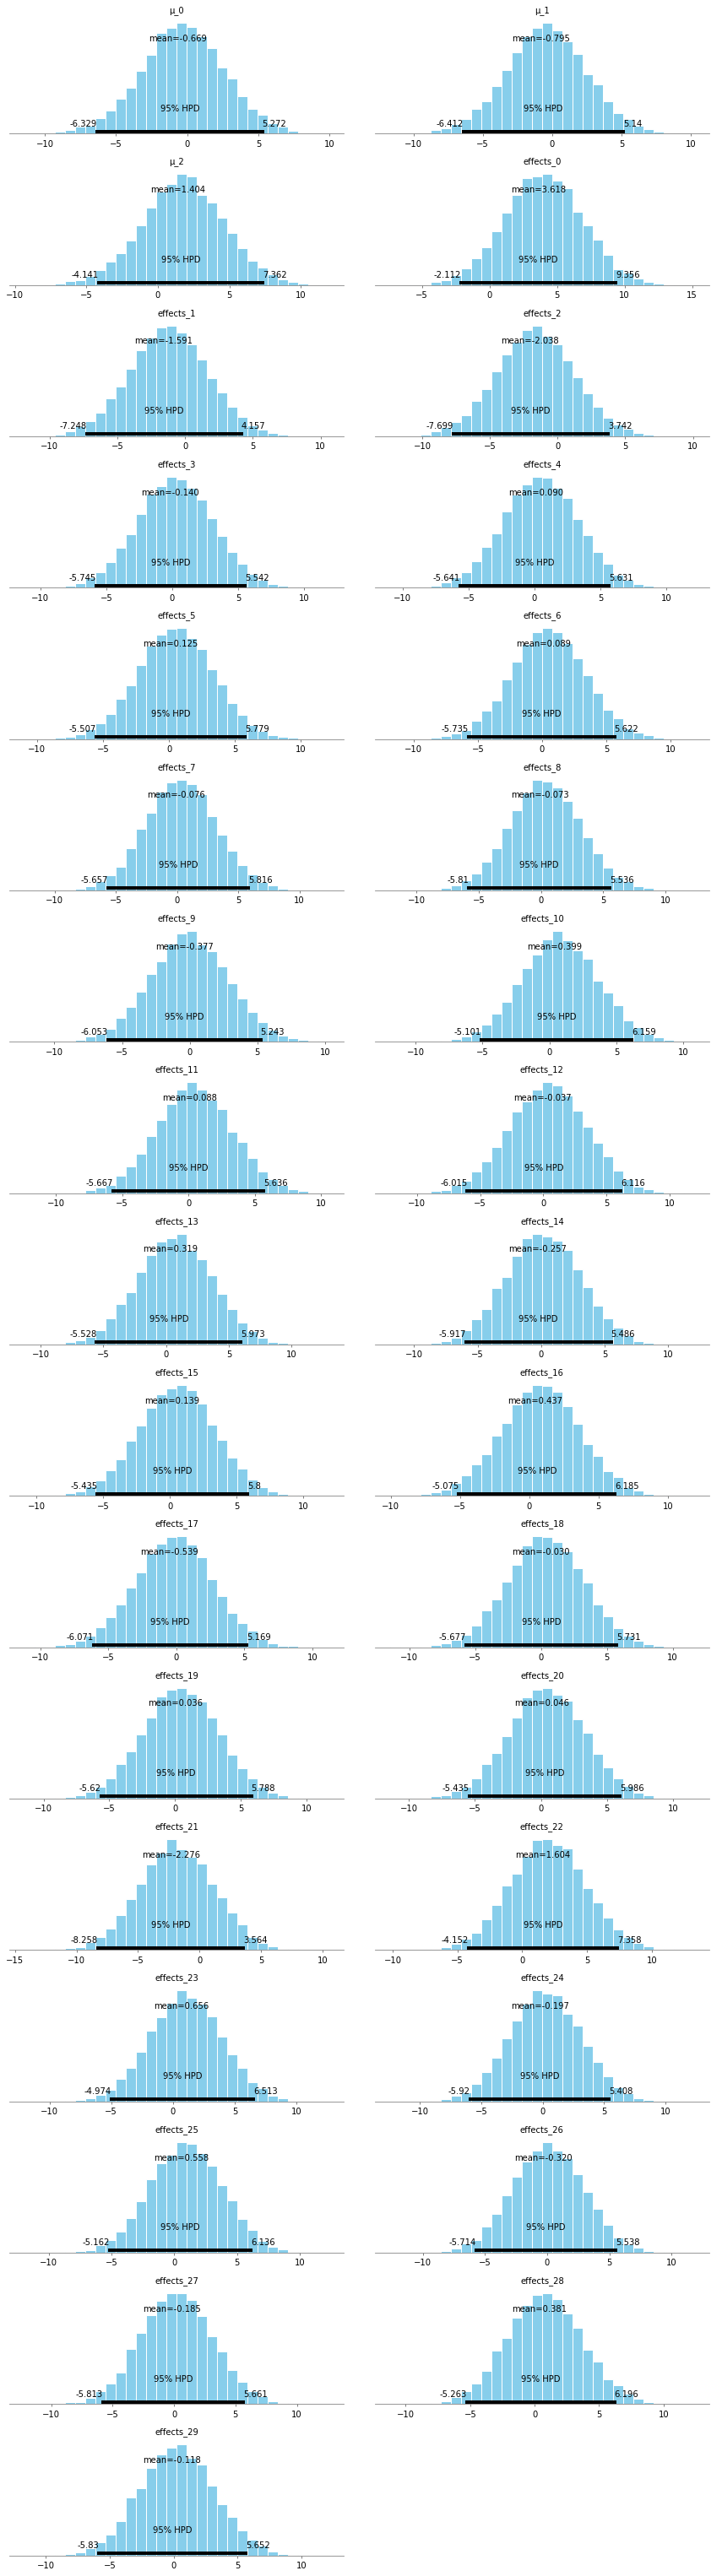

In [516]:
pm.plots.plot_posterior(trace, varnames = ["μ", "effects"]);

# Posterior predictive check
How does the model perform in predicting the outcomes of the subjects that went into the data?

In [517]:
ppc = pm.sample_ppc(trace, samples=500, model=logistic_model)

100%|██████████| 500/500 [00:11<00:00, 42.09it/s]


In [518]:
len(ppc['Y_obs'][:,0])

500

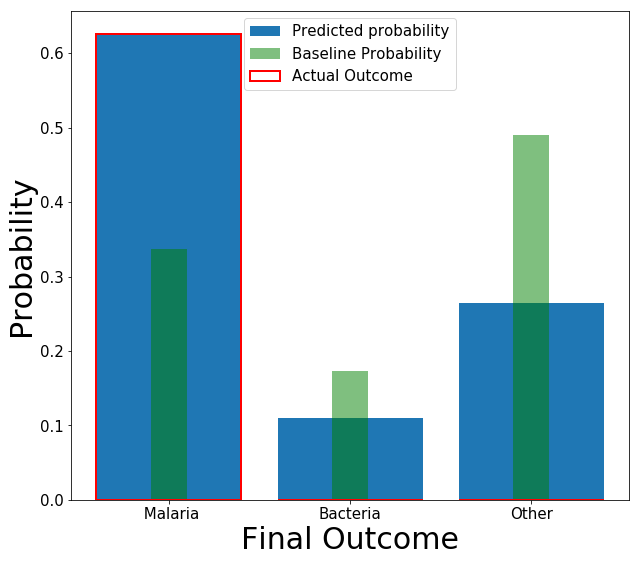

In [519]:
#ppc for person 0, example of a true malaria case
ind = 0
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

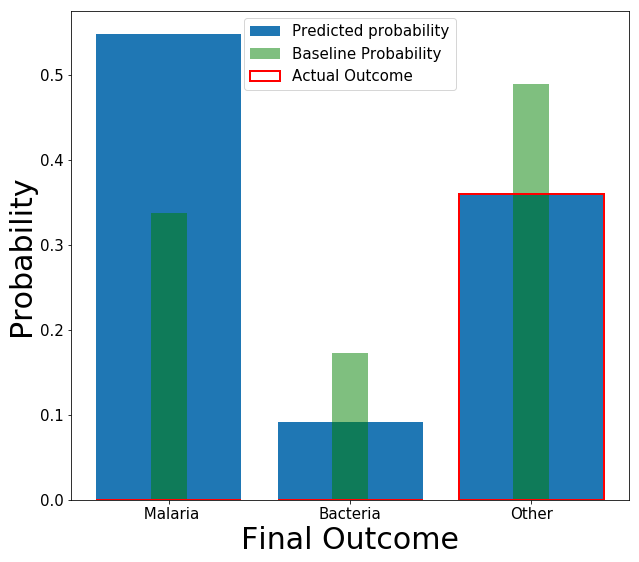

In [520]:
#ppc for person 1, example of a true neither case, note that positive rdttest makes this one miss badly
ind = 1
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

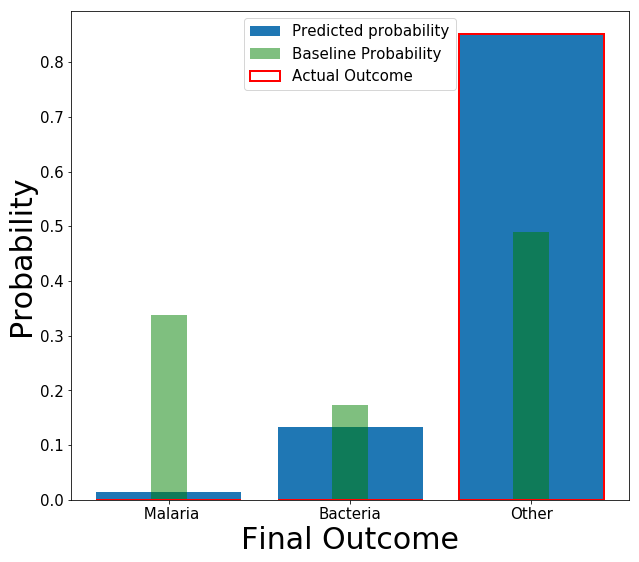

In [521]:
#ppc for person 3, negative rdt test makes this one very certain (accuratley this time)
ind = 3
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

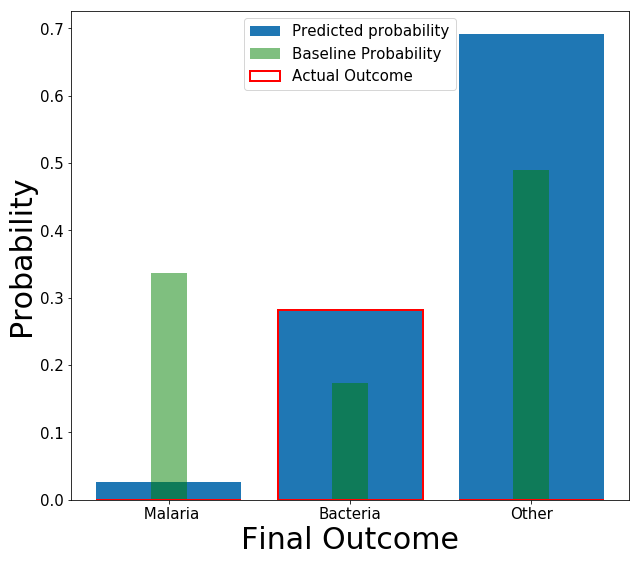

In [522]:
#ppc for person 10, example of a true bacteria
ind = 10
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

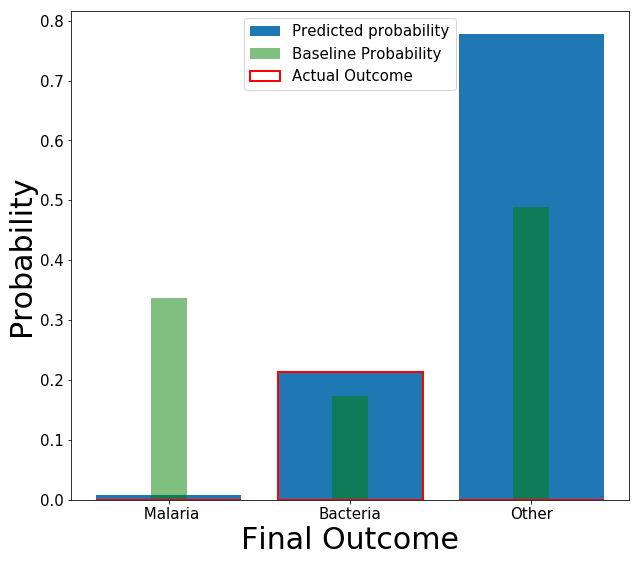

In [523]:
#ppc for person 251, example of a true bacteria
ind = 251
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 0) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 1) / 500),
    np.asscalar(sum(ppc['Y_obs'][:,ind] == 2) / 500)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(ppc['Y_obs'][:,ind] == 0) / 500,
                 (y[ind] == 1).astype(int)*sum(ppc['Y_obs'][:,ind] == 1) / 500,
                 (y[ind] == 2).astype(int)*sum(ppc['Y_obs'][:,ind] == 2) / 500], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

In [525]:
result = pd.DataFrame({'diag':y})
result['rdtresult'] = rdtresult
result['p_mal'] = np.sum(ppc['Y_obs'][:,:] == 0, axis = 0) / 500
result['p_bact'] = np.sum(ppc['Y_obs'][:,:] == 1, axis = 0) / 500
result['p_other'] = np.sum(ppc['Y_obs'][:,:] == 2, axis = 0) / 500
#result['p_max'] = np.amax(result.drop(['diag'], axis=1), axis = 1)
#result['prediction'] = 0
#result['prediction'][np.where(result['p_max'] == result['p_bact'], 'yes', 'no') == 'yes'] = 1
#result['prediction'][np.where(result['p_max'] == result['p_other'], 'yes', 'no') == 'yes'] = 2

# Brier Score
This is a measure of model certainty and accuracy  
https://en.wikipedia.org/wiki/Brier_score

In [526]:
p_mal = result['p_mal']
p_bact = result['p_bact']
p_other = result['p_other']
d_mal = (result['diag'] == 0).astype(int)
d_bact = (result['diag'] == 1).astype(int)
d_other = (result['diag'] == 2).astype(int)
BS = (sum(np.square(p_mal - d_mal)) + sum(np.square(p_bact - d_bact)) + sum(np.square(p_other - d_other))) / len(y)
BS

0.3416924833333334

# More intuitive: Given someone is a true positive, how does it affect their prediction for that outcome?
We start by knowing the baseline prediction, which comes from prevavlence in a sample (if we know nothing about a person we assume their probability based solely from population averages.)

%malaria: .324  
%bacteria: .166  
%other: .470

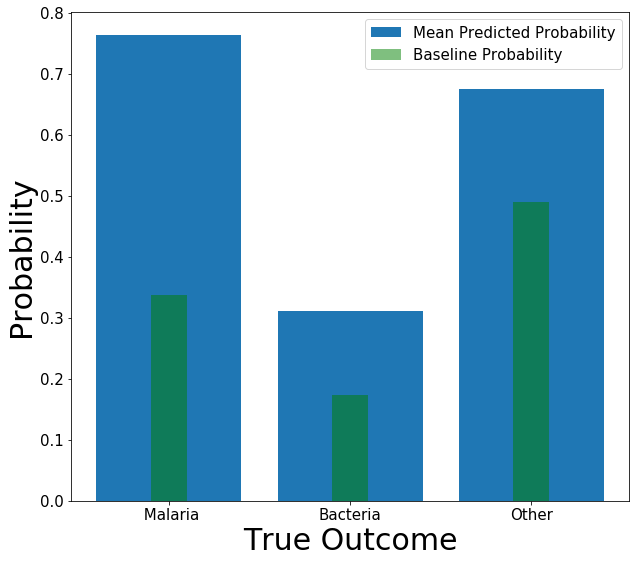

In [527]:
#Average predicted prob of outcome given outcome
avg_mal_prob = sum(p_mal * d_mal) / sum(d_mal)
avg_bact_prob = sum(p_bact * d_bact) / sum(d_bact)
avg_other_prob = sum(p_other * d_other) / sum(d_other)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')



plt.legend(loc = 1 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

This plot suggests improved prediction by the regression.  Because the model was built in a primarily non-data-driven way and exploits linear relationships between predictor and outcome it is unlikely that this is due to overfitting.  If a bootstrapped sample has similarly good predictive power it should provide evidence of internal validation and confidence that overfitting is not a problem.

# Resimulating outcomes based on MLEs of coefficients
This should be very similar to the PPC but is generalizeable to new data so if someone new were in need of prediction this is the process that would generate their predicted outcomes.

In [528]:
coef = pm.summary(trace, varnames = ["effects"])


In [529]:
#Make a Matrix the rows of which are beta1, ...., betak and the columns represent mal, bact, and other.

coef_mal = coef.iloc[::3, 0]
coef_bact = coef.iloc[1::3, 0]
coef_other = coef.iloc[2::3, 0]


In [530]:
coef_matrix = pd.DataFrame({"coef_mal":coef_mal})
coef_matrix["coef_bact"] = coef_bact.values
coef_matrix["coef_other"] = coef_other.values
mu_vect = pm.summary(trace, varnames = ["μ"])["mean"].values


In [532]:
with pm.Model() as posterior_sim:
    
    # Impute continuous variables
    if np.isnan(sbp).sum():
        mu_sbp = pm.Uniform("mu_sbp", lower = 50, upper = 200)
        var_sbp = pm.HalfNormal('var_sbp', sd = 1)
        x_sbp = pm.Normal('x_sbp', mu = mu_sbp, sd = var_sbp, observed=np.ma.masked_invalid(sbp))
    else:
        x_sbp = sbp
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_invalid(muac))
    else:
        x_muac = muac
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_invalid(rdtresult))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_invalid(vacmen))
    else:
        x_vacmen = vacmen          
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_invalid(incphoto))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_invalid(incirrit))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_invalid(incfont))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_invalid(incneck))
    else:
        x_incneck = incneck
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_invalid(incseizh))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult, x_glasgtot, x_vacmen, female, x_incphoto, x_incirrit,
        x_muac, x_incfont, x_incneck, x_incseizh]

    N, K = len(X), len(set(y))
    
    μ = mu_vect
    effects = coef_matrix.values
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis=1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    #Y_post = pm.Categorical('Y_post', p=p.T, shape = 1)

#    count = 0
#    while count < 479:
#        varname = "Ypost" + str(count)
#        count += 1
#        mod = pm.Categorical(name= varname, p=p[count,:])
    
    Ypost0= pm.Categorical(name = 'Ypost0' , p=p[0,:] )
    Ypost1= pm.Categorical(name = 'Ypost1' , p=p[1,:] )
    Ypost2= pm.Categorical(name = 'Ypost2' , p=p[2,:] )
    Ypost3= pm.Categorical(name = 'Ypost3' , p=p[3,:] )
    Ypost4= pm.Categorical(name = 'Ypost4' , p=p[4,:] )
    Ypost5= pm.Categorical(name = 'Ypost5' , p=p[5,:] )
    Ypost6= pm.Categorical(name = 'Ypost6' , p=p[6,:] )
    Ypost7= pm.Categorical(name = 'Ypost7' , p=p[7,:] )
    Ypost8= pm.Categorical(name = 'Ypost8' , p=p[8,:] )
    Ypost9= pm.Categorical(name = 'Ypost9' , p=p[9,:] )
    Ypost10= pm.Categorical(name = 'Ypost10' , p=p[10,:] )
    Ypost11= pm.Categorical(name = 'Ypost11' , p=p[11,:] )
    Ypost12= pm.Categorical(name = 'Ypost12' , p=p[12,:] )
    Ypost13= pm.Categorical(name = 'Ypost13' , p=p[13,:] )
    Ypost14= pm.Categorical(name = 'Ypost14' , p=p[14,:] )
    Ypost15= pm.Categorical(name = 'Ypost15' , p=p[15,:] )
    Ypost16= pm.Categorical(name = 'Ypost16' , p=p[16,:] )
    Ypost17= pm.Categorical(name = 'Ypost17' , p=p[17,:] )
    Ypost18= pm.Categorical(name = 'Ypost18' , p=p[18,:] )
    Ypost19= pm.Categorical(name = 'Ypost19' , p=p[19,:] )
    Ypost20= pm.Categorical(name = 'Ypost20' , p=p[20,:] )
    Ypost21= pm.Categorical(name = 'Ypost21' , p=p[21,:] )
    Ypost22= pm.Categorical(name = 'Ypost22' , p=p[22,:] )
    Ypost23= pm.Categorical(name = 'Ypost23' , p=p[23,:] )
    Ypost24= pm.Categorical(name = 'Ypost24' , p=p[24,:] )
    Ypost25= pm.Categorical(name = 'Ypost25' , p=p[25,:] )
    Ypost26= pm.Categorical(name = 'Ypost26' , p=p[26,:] )
    Ypost27= pm.Categorical(name = 'Ypost27' , p=p[27,:] )
    Ypost28= pm.Categorical(name = 'Ypost28' , p=p[28,:] )
    Ypost29= pm.Categorical(name = 'Ypost29' , p=p[29,:] )
    Ypost30= pm.Categorical(name = 'Ypost30' , p=p[30,:] )
    Ypost31= pm.Categorical(name = 'Ypost31' , p=p[31,:] )
    Ypost32= pm.Categorical(name = 'Ypost32' , p=p[32,:] )
    Ypost33= pm.Categorical(name = 'Ypost33' , p=p[33,:] )
    Ypost34= pm.Categorical(name = 'Ypost34' , p=p[34,:] )
    Ypost35= pm.Categorical(name = 'Ypost35' , p=p[35,:] )
    Ypost36= pm.Categorical(name = 'Ypost36' , p=p[36,:] )
    Ypost37= pm.Categorical(name = 'Ypost37' , p=p[37,:] )
    Ypost38= pm.Categorical(name = 'Ypost38' , p=p[38,:] )
    Ypost39= pm.Categorical(name = 'Ypost39' , p=p[39,:] )
    Ypost40= pm.Categorical(name = 'Ypost40' , p=p[40,:] )
    Ypost41= pm.Categorical(name = 'Ypost41' , p=p[41,:] )
    Ypost42= pm.Categorical(name = 'Ypost42' , p=p[42,:] )
    Ypost43= pm.Categorical(name = 'Ypost43' , p=p[43,:] )
    Ypost44= pm.Categorical(name = 'Ypost44' , p=p[44,:] )
    Ypost45= pm.Categorical(name = 'Ypost45' , p=p[45,:] )
    Ypost46= pm.Categorical(name = 'Ypost46' , p=p[46,:] )
    Ypost47= pm.Categorical(name = 'Ypost47' , p=p[47,:] )
    Ypost48= pm.Categorical(name = 'Ypost48' , p=p[48,:] )
    Ypost49= pm.Categorical(name = 'Ypost49' , p=p[49,:] )
    Ypost50= pm.Categorical(name = 'Ypost50' , p=p[50,:] )
    Ypost51= pm.Categorical(name = 'Ypost51' , p=p[51,:] )
    Ypost52= pm.Categorical(name = 'Ypost52' , p=p[52,:] )
    Ypost53= pm.Categorical(name = 'Ypost53' , p=p[53,:] )
    Ypost54= pm.Categorical(name = 'Ypost54' , p=p[54,:] )
    Ypost55= pm.Categorical(name = 'Ypost55' , p=p[55,:] )
    Ypost56= pm.Categorical(name = 'Ypost56' , p=p[56,:] )
    Ypost57= pm.Categorical(name = 'Ypost57' , p=p[57,:] )
    Ypost58= pm.Categorical(name = 'Ypost58' , p=p[58,:] )
    Ypost59= pm.Categorical(name = 'Ypost59' , p=p[59,:] )
    Ypost60= pm.Categorical(name = 'Ypost60' , p=p[60,:] )
    Ypost61= pm.Categorical(name = 'Ypost61' , p=p[61,:] )
    Ypost62= pm.Categorical(name = 'Ypost62' , p=p[62,:] )
    Ypost63= pm.Categorical(name = 'Ypost63' , p=p[63,:] )
    Ypost64= pm.Categorical(name = 'Ypost64' , p=p[64,:] )
    Ypost65= pm.Categorical(name = 'Ypost65' , p=p[65,:] )
    Ypost66= pm.Categorical(name = 'Ypost66' , p=p[66,:] )
    Ypost67= pm.Categorical(name = 'Ypost67' , p=p[67,:] )
    Ypost68= pm.Categorical(name = 'Ypost68' , p=p[68,:] )
    Ypost69= pm.Categorical(name = 'Ypost69' , p=p[69,:] )
    Ypost70= pm.Categorical(name = 'Ypost70' , p=p[70,:] )
    Ypost71= pm.Categorical(name = 'Ypost71' , p=p[71,:] )
    Ypost72= pm.Categorical(name = 'Ypost72' , p=p[72,:] )
    Ypost73= pm.Categorical(name = 'Ypost73' , p=p[73,:] )
    Ypost74= pm.Categorical(name = 'Ypost74' , p=p[74,:] )
    Ypost75= pm.Categorical(name = 'Ypost75' , p=p[75,:] )
    Ypost76= pm.Categorical(name = 'Ypost76' , p=p[76,:] )
    Ypost77= pm.Categorical(name = 'Ypost77' , p=p[77,:] )
    Ypost78= pm.Categorical(name = 'Ypost78' , p=p[78,:] )
    Ypost79= pm.Categorical(name = 'Ypost79' , p=p[79,:] )
    Ypost80= pm.Categorical(name = 'Ypost80' , p=p[80,:] )
    Ypost81= pm.Categorical(name = 'Ypost81' , p=p[81,:] )
    Ypost82= pm.Categorical(name = 'Ypost82' , p=p[82,:] )
    Ypost83= pm.Categorical(name = 'Ypost83' , p=p[83,:] )
    Ypost84= pm.Categorical(name = 'Ypost84' , p=p[84,:] )
    Ypost85= pm.Categorical(name = 'Ypost85' , p=p[85,:] )
    Ypost86= pm.Categorical(name = 'Ypost86' , p=p[86,:] )
    Ypost87= pm.Categorical(name = 'Ypost87' , p=p[87,:] )
    Ypost88= pm.Categorical(name = 'Ypost88' , p=p[88,:] )
    Ypost89= pm.Categorical(name = 'Ypost89' , p=p[89,:] )
    Ypost90= pm.Categorical(name = 'Ypost90' , p=p[90,:] )
    Ypost91= pm.Categorical(name = 'Ypost91' , p=p[91,:] )
    Ypost92= pm.Categorical(name = 'Ypost92' , p=p[92,:] )
    Ypost93= pm.Categorical(name = 'Ypost93' , p=p[93,:] )
    Ypost94= pm.Categorical(name = 'Ypost94' , p=p[94,:] )
    Ypost95= pm.Categorical(name = 'Ypost95' , p=p[95,:] )
    Ypost96= pm.Categorical(name = 'Ypost96' , p=p[96,:] )
    Ypost97= pm.Categorical(name = 'Ypost97' , p=p[97,:] )
    Ypost98= pm.Categorical(name = 'Ypost98' , p=p[98,:] )
    Ypost99= pm.Categorical(name = 'Ypost99' , p=p[99,:] )
    Ypost100= pm.Categorical(name = 'Ypost100' , p=p[100,:] )
    Ypost101= pm.Categorical(name = 'Ypost101' , p=p[101,:] )
    Ypost102= pm.Categorical(name = 'Ypost102' , p=p[102,:] )
    Ypost103= pm.Categorical(name = 'Ypost103' , p=p[103,:] )
    Ypost104= pm.Categorical(name = 'Ypost104' , p=p[104,:] )
    Ypost105= pm.Categorical(name = 'Ypost105' , p=p[105,:] )
    Ypost106= pm.Categorical(name = 'Ypost106' , p=p[106,:] )
    Ypost107= pm.Categorical(name = 'Ypost107' , p=p[107,:] )
    Ypost108= pm.Categorical(name = 'Ypost108' , p=p[108,:] )
    Ypost109= pm.Categorical(name = 'Ypost109' , p=p[109,:] )
    Ypost110= pm.Categorical(name = 'Ypost110' , p=p[110,:] )
    Ypost111= pm.Categorical(name = 'Ypost111' , p=p[111,:] )
    Ypost112= pm.Categorical(name = 'Ypost112' , p=p[112,:] )
    Ypost113= pm.Categorical(name = 'Ypost113' , p=p[113,:] )
    Ypost114= pm.Categorical(name = 'Ypost114' , p=p[114,:] )
    Ypost115= pm.Categorical(name = 'Ypost115' , p=p[115,:] )
    Ypost116= pm.Categorical(name = 'Ypost116' , p=p[116,:] )
    Ypost117= pm.Categorical(name = 'Ypost117' , p=p[117,:] )
    Ypost118= pm.Categorical(name = 'Ypost118' , p=p[118,:] )
    Ypost119= pm.Categorical(name = 'Ypost119' , p=p[119,:] )
    Ypost120= pm.Categorical(name = 'Ypost120' , p=p[120,:] )
    Ypost121= pm.Categorical(name = 'Ypost121' , p=p[121,:] )
    Ypost122= pm.Categorical(name = 'Ypost122' , p=p[122,:] )
    Ypost123= pm.Categorical(name = 'Ypost123' , p=p[123,:] )
    Ypost124= pm.Categorical(name = 'Ypost124' , p=p[124,:] )
    Ypost125= pm.Categorical(name = 'Ypost125' , p=p[125,:] )
    Ypost126= pm.Categorical(name = 'Ypost126' , p=p[126,:] )
    Ypost127= pm.Categorical(name = 'Ypost127' , p=p[127,:] )
    Ypost128= pm.Categorical(name = 'Ypost128' , p=p[128,:] )
    Ypost129= pm.Categorical(name = 'Ypost129' , p=p[129,:] )
    Ypost130= pm.Categorical(name = 'Ypost130' , p=p[130,:] )
    Ypost131= pm.Categorical(name = 'Ypost131' , p=p[131,:] )
    Ypost132= pm.Categorical(name = 'Ypost132' , p=p[132,:] )
    Ypost133= pm.Categorical(name = 'Ypost133' , p=p[133,:] )
    Ypost134= pm.Categorical(name = 'Ypost134' , p=p[134,:] )
    Ypost135= pm.Categorical(name = 'Ypost135' , p=p[135,:] )
    Ypost136= pm.Categorical(name = 'Ypost136' , p=p[136,:] )
    Ypost137= pm.Categorical(name = 'Ypost137' , p=p[137,:] )
    Ypost138= pm.Categorical(name = 'Ypost138' , p=p[138,:] )
    Ypost139= pm.Categorical(name = 'Ypost139' , p=p[139,:] )
    Ypost140= pm.Categorical(name = 'Ypost140' , p=p[140,:] )
    Ypost141= pm.Categorical(name = 'Ypost141' , p=p[141,:] )
    Ypost142= pm.Categorical(name = 'Ypost142' , p=p[142,:] )
    Ypost143= pm.Categorical(name = 'Ypost143' , p=p[143,:] )
    Ypost144= pm.Categorical(name = 'Ypost144' , p=p[144,:] )
    Ypost145= pm.Categorical(name = 'Ypost145' , p=p[145,:] )
    Ypost146= pm.Categorical(name = 'Ypost146' , p=p[146,:] )
    Ypost147= pm.Categorical(name = 'Ypost147' , p=p[147,:] )
    Ypost148= pm.Categorical(name = 'Ypost148' , p=p[148,:] )
    Ypost149= pm.Categorical(name = 'Ypost149' , p=p[149,:] )
    Ypost150= pm.Categorical(name = 'Ypost150' , p=p[150,:] )
    Ypost151= pm.Categorical(name = 'Ypost151' , p=p[151,:] )
    Ypost152= pm.Categorical(name = 'Ypost152' , p=p[152,:] )
    Ypost153= pm.Categorical(name = 'Ypost153' , p=p[153,:] )
    Ypost154= pm.Categorical(name = 'Ypost154' , p=p[154,:] )
    Ypost155= pm.Categorical(name = 'Ypost155' , p=p[155,:] )
    Ypost156= pm.Categorical(name = 'Ypost156' , p=p[156,:] )
    Ypost157= pm.Categorical(name = 'Ypost157' , p=p[157,:] )
    Ypost158= pm.Categorical(name = 'Ypost158' , p=p[158,:] )
    Ypost159= pm.Categorical(name = 'Ypost159' , p=p[159,:] )
    Ypost160= pm.Categorical(name = 'Ypost160' , p=p[160,:] )
    Ypost161= pm.Categorical(name = 'Ypost161' , p=p[161,:] )
    Ypost162= pm.Categorical(name = 'Ypost162' , p=p[162,:] )
    Ypost163= pm.Categorical(name = 'Ypost163' , p=p[163,:] )
    Ypost164= pm.Categorical(name = 'Ypost164' , p=p[164,:] )
    Ypost165= pm.Categorical(name = 'Ypost165' , p=p[165,:] )
    Ypost166= pm.Categorical(name = 'Ypost166' , p=p[166,:] )
    Ypost167= pm.Categorical(name = 'Ypost167' , p=p[167,:] )
    Ypost168= pm.Categorical(name = 'Ypost168' , p=p[168,:] )
    Ypost169= pm.Categorical(name = 'Ypost169' , p=p[169,:] )
    Ypost170= pm.Categorical(name = 'Ypost170' , p=p[170,:] )
    Ypost171= pm.Categorical(name = 'Ypost171' , p=p[171,:] )
    Ypost172= pm.Categorical(name = 'Ypost172' , p=p[172,:] )
    Ypost173= pm.Categorical(name = 'Ypost173' , p=p[173,:] )
    Ypost174= pm.Categorical(name = 'Ypost174' , p=p[174,:] )
    Ypost175= pm.Categorical(name = 'Ypost175' , p=p[175,:] )
    Ypost176= pm.Categorical(name = 'Ypost176' , p=p[176,:] )
    Ypost177= pm.Categorical(name = 'Ypost177' , p=p[177,:] )
    Ypost178= pm.Categorical(name = 'Ypost178' , p=p[178,:] )
    Ypost179= pm.Categorical(name = 'Ypost179' , p=p[179,:] )
    Ypost180= pm.Categorical(name = 'Ypost180' , p=p[180,:] )
    Ypost181= pm.Categorical(name = 'Ypost181' , p=p[181,:] )
    Ypost182= pm.Categorical(name = 'Ypost182' , p=p[182,:] )
    Ypost183= pm.Categorical(name = 'Ypost183' , p=p[183,:] )
    Ypost184= pm.Categorical(name = 'Ypost184' , p=p[184,:] )
    Ypost185= pm.Categorical(name = 'Ypost185' , p=p[185,:] )
    Ypost186= pm.Categorical(name = 'Ypost186' , p=p[186,:] )
    Ypost187= pm.Categorical(name = 'Ypost187' , p=p[187,:] )
    Ypost188= pm.Categorical(name = 'Ypost188' , p=p[188,:] )
    Ypost189= pm.Categorical(name = 'Ypost189' , p=p[189,:] )
    Ypost190= pm.Categorical(name = 'Ypost190' , p=p[190,:] )
    Ypost191= pm.Categorical(name = 'Ypost191' , p=p[191,:] )
    Ypost192= pm.Categorical(name = 'Ypost192' , p=p[192,:] )
    Ypost193= pm.Categorical(name = 'Ypost193' , p=p[193,:] )
    Ypost194= pm.Categorical(name = 'Ypost194' , p=p[194,:] )
    Ypost195= pm.Categorical(name = 'Ypost195' , p=p[195,:] )
    Ypost196= pm.Categorical(name = 'Ypost196' , p=p[196,:] )
    Ypost197= pm.Categorical(name = 'Ypost197' , p=p[197,:] )
    Ypost198= pm.Categorical(name = 'Ypost198' , p=p[198,:] )
    Ypost199= pm.Categorical(name = 'Ypost199' , p=p[199,:] )
    Ypost200= pm.Categorical(name = 'Ypost200' , p=p[200,:] )





INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


In [539]:
with posterior_sim:
    sim_trace = pm.sample(500, tune=500, cores = 2)

INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac, x_sbp_missing, var_sbp, mu_sbp]
>CategoricalGibbsMetropolis: [Ypost200, Ypost199, Ypost198, Ypost197, Ypost196, Ypost195, Ypost194, Ypost193, Ypost192, Ypost191, Ypost190, Ypost189, Ypost188, Ypost187, Ypost186, Ypost185, Ypost184, Ypost183, Ypost182, Ypost181, Ypost180, Ypost179, Ypost178, Ypost177, Ypost176, Ypost175, Ypost174, Ypost173, Ypost172, Ypost171, Ypost170, Ypost169, Ypost168, Ypost167, Ypost166, Ypost165, Ypost164, Ypost163, Ypost162, Ypost161, Ypost160, Ypost159, Ypost158, Ypost157, Ypost156, Ypost155, Ypost154, Ypost153, Ypost152, Ypost151, Ypost150, Ypost149, Ypost148, Ypost147, Ypost146, Ypost145, Ypost144, Ypost143, Ypost142, Ypost141, Ypost

In [534]:
with pm.Model() as posterior_sim2:
    
    # Impute continuous variables
    if np.isnan(sbp).sum():
        mu_sbp = pm.Uniform("mu_sbp", lower = 50, upper = 200)
        var_sbp = pm.HalfNormal('var_sbp', sd = 1)
        x_sbp = pm.Normal('x_sbp', mu = mu_sbp, sd = var_sbp, observed=np.ma.masked_invalid(sbp))
    else:
        x_sbp = sbp
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_invalid(muac))
    else:
        x_muac = muac
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_invalid(rdtresult))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_invalid(vacmen))
    else:
        x_vacmen = vacmen          
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_invalid(incphoto))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_invalid(incirrit))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_invalid(incfont))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_invalid(incneck))
    else:
        x_incneck = incneck
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_invalid(incseizh))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult, x_glasgtot, x_vacmen, female, x_incphoto, x_incirrit, 
        x_incfont, x_incneck, x_incseizh, incseiza]

    N, K = len(X), len(set(y))
    
    μ = mu_vect
    effects = coef_matrix.values
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis=1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    #Y_post = pm.Categorical('Y_post', p=p.T, shape = 1)

#    count = 0
#    while count < 479:
#        varname = "Ypost" + str(count)
#        count += 1
#        mod = pm.Categorical(name= varname, p=p[count,:])
    
    Ypost201= pm.Categorical(name = 'Ypost201' , p=p[201,:] )
    Ypost202= pm.Categorical(name = 'Ypost202' , p=p[202,:] )
    Ypost203= pm.Categorical(name = 'Ypost203' , p=p[203,:] )
    Ypost204= pm.Categorical(name = 'Ypost204' , p=p[204,:] )
    Ypost205= pm.Categorical(name = 'Ypost205' , p=p[205,:] )
    Ypost206= pm.Categorical(name = 'Ypost206' , p=p[206,:] )
    Ypost207= pm.Categorical(name = 'Ypost207' , p=p[207,:] )
    Ypost208= pm.Categorical(name = 'Ypost208' , p=p[208,:] )
    Ypost209= pm.Categorical(name = 'Ypost209' , p=p[209,:] )
    Ypost210= pm.Categorical(name = 'Ypost210' , p=p[210,:] )
    Ypost211= pm.Categorical(name = 'Ypost211' , p=p[211,:] )
    Ypost212= pm.Categorical(name = 'Ypost212' , p=p[212,:] )
    Ypost213= pm.Categorical(name = 'Ypost213' , p=p[213,:] )
    Ypost214= pm.Categorical(name = 'Ypost214' , p=p[214,:] )
    Ypost215= pm.Categorical(name = 'Ypost215' , p=p[215,:] )
    Ypost216= pm.Categorical(name = 'Ypost216' , p=p[216,:] )
    Ypost217= pm.Categorical(name = 'Ypost217' , p=p[217,:] )
    Ypost218= pm.Categorical(name = 'Ypost218' , p=p[218,:] )
    Ypost219= pm.Categorical(name = 'Ypost219' , p=p[219,:] )
    Ypost220= pm.Categorical(name = 'Ypost220' , p=p[220,:] )
    Ypost221= pm.Categorical(name = 'Ypost221' , p=p[221,:] )
    Ypost222= pm.Categorical(name = 'Ypost222' , p=p[222,:] )
    Ypost223= pm.Categorical(name = 'Ypost223' , p=p[223,:] )
    Ypost224= pm.Categorical(name = 'Ypost224' , p=p[224,:] )
    Ypost225= pm.Categorical(name = 'Ypost225' , p=p[225,:] )
    Ypost226= pm.Categorical(name = 'Ypost226' , p=p[226,:] )
    Ypost227= pm.Categorical(name = 'Ypost227' , p=p[227,:] )
    Ypost228= pm.Categorical(name = 'Ypost228' , p=p[228,:] )
    Ypost229= pm.Categorical(name = 'Ypost229' , p=p[229,:] )
    Ypost230= pm.Categorical(name = 'Ypost230' , p=p[230,:] )
    Ypost231= pm.Categorical(name = 'Ypost231' , p=p[231,:] )
    Ypost232= pm.Categorical(name = 'Ypost232' , p=p[232,:] )
    Ypost233= pm.Categorical(name = 'Ypost233' , p=p[233,:] )
    Ypost234= pm.Categorical(name = 'Ypost234' , p=p[234,:] )
    Ypost235= pm.Categorical(name = 'Ypost235' , p=p[235,:] )
    Ypost236= pm.Categorical(name = 'Ypost236' , p=p[236,:] )
    Ypost237= pm.Categorical(name = 'Ypost237' , p=p[237,:] )
    Ypost238= pm.Categorical(name = 'Ypost238' , p=p[238,:] )
    Ypost239= pm.Categorical(name = 'Ypost239' , p=p[239,:] )
    Ypost240= pm.Categorical(name = 'Ypost240' , p=p[240,:] )
    Ypost241= pm.Categorical(name = 'Ypost241' , p=p[241,:] )
    Ypost242= pm.Categorical(name = 'Ypost242' , p=p[242,:] )
    Ypost243= pm.Categorical(name = 'Ypost243' , p=p[243,:] )
    Ypost244= pm.Categorical(name = 'Ypost244' , p=p[244,:] )
    Ypost245= pm.Categorical(name = 'Ypost245' , p=p[245,:] )
    Ypost246= pm.Categorical(name = 'Ypost246' , p=p[246,:] )
    Ypost247= pm.Categorical(name = 'Ypost247' , p=p[247,:] )
    Ypost248= pm.Categorical(name = 'Ypost248' , p=p[248,:] )
    Ypost249= pm.Categorical(name = 'Ypost249' , p=p[249,:] )
    Ypost250= pm.Categorical(name = 'Ypost250' , p=p[250,:] )
    Ypost251= pm.Categorical(name = 'Ypost251' , p=p[251,:] )
    Ypost252= pm.Categorical(name = 'Ypost252' , p=p[252,:] )
    Ypost253= pm.Categorical(name = 'Ypost253' , p=p[253,:] )
    Ypost254= pm.Categorical(name = 'Ypost254' , p=p[254,:] )
    Ypost255= pm.Categorical(name = 'Ypost255' , p=p[255,:] )
    Ypost256= pm.Categorical(name = 'Ypost256' , p=p[256,:] )
    Ypost257= pm.Categorical(name = 'Ypost257' , p=p[257,:] )
    Ypost258= pm.Categorical(name = 'Ypost258' , p=p[258,:] )
    Ypost259= pm.Categorical(name = 'Ypost259' , p=p[259,:] )
    Ypost260= pm.Categorical(name = 'Ypost260' , p=p[260,:] )
    Ypost261= pm.Categorical(name = 'Ypost261' , p=p[261,:] )
    Ypost262= pm.Categorical(name = 'Ypost262' , p=p[262,:] )
    Ypost263= pm.Categorical(name = 'Ypost263' , p=p[263,:] )
    Ypost264= pm.Categorical(name = 'Ypost264' , p=p[264,:] )
    Ypost265= pm.Categorical(name = 'Ypost265' , p=p[265,:] )
    Ypost266= pm.Categorical(name = 'Ypost266' , p=p[266,:] )
    Ypost267= pm.Categorical(name = 'Ypost267' , p=p[267,:] )
    Ypost268= pm.Categorical(name = 'Ypost268' , p=p[268,:] )
    Ypost269= pm.Categorical(name = 'Ypost269' , p=p[269,:] )
    Ypost270= pm.Categorical(name = 'Ypost270' , p=p[270,:] )
    Ypost271= pm.Categorical(name = 'Ypost271' , p=p[271,:] )
    Ypost272= pm.Categorical(name = 'Ypost272' , p=p[272,:] )
    Ypost273= pm.Categorical(name = 'Ypost273' , p=p[273,:] )
    Ypost274= pm.Categorical(name = 'Ypost274' , p=p[274,:] )
    Ypost275= pm.Categorical(name = 'Ypost275' , p=p[275,:] )
    Ypost276= pm.Categorical(name = 'Ypost276' , p=p[276,:] )
    Ypost277= pm.Categorical(name = 'Ypost277' , p=p[277,:] )
    Ypost278= pm.Categorical(name = 'Ypost278' , p=p[278,:] )
    Ypost279= pm.Categorical(name = 'Ypost279' , p=p[279,:] )
    Ypost280= pm.Categorical(name = 'Ypost280' , p=p[280,:] )
    Ypost281= pm.Categorical(name = 'Ypost281' , p=p[281,:] )
    Ypost282= pm.Categorical(name = 'Ypost282' , p=p[282,:] )
    Ypost283= pm.Categorical(name = 'Ypost283' , p=p[283,:] )
    Ypost284= pm.Categorical(name = 'Ypost284' , p=p[284,:] )
    Ypost285= pm.Categorical(name = 'Ypost285' , p=p[285,:] )
    Ypost286= pm.Categorical(name = 'Ypost286' , p=p[286,:] )
    Ypost287= pm.Categorical(name = 'Ypost287' , p=p[287,:] )
    Ypost288= pm.Categorical(name = 'Ypost288' , p=p[288,:] )
    Ypost289= pm.Categorical(name = 'Ypost289' , p=p[289,:] )
    Ypost290= pm.Categorical(name = 'Ypost290' , p=p[290,:] )
    Ypost291= pm.Categorical(name = 'Ypost291' , p=p[291,:] )
    Ypost292= pm.Categorical(name = 'Ypost292' , p=p[292,:] )
    Ypost293= pm.Categorical(name = 'Ypost293' , p=p[293,:] )
    Ypost294= pm.Categorical(name = 'Ypost294' , p=p[294,:] )
    Ypost295= pm.Categorical(name = 'Ypost295' , p=p[295,:] )
    Ypost296= pm.Categorical(name = 'Ypost296' , p=p[296,:] )
    Ypost297= pm.Categorical(name = 'Ypost297' , p=p[297,:] )
    Ypost298= pm.Categorical(name = 'Ypost298' , p=p[298,:] )
    Ypost299= pm.Categorical(name = 'Ypost299' , p=p[299,:] )
    Ypost300= pm.Categorical(name = 'Ypost300' , p=p[300,:] )
    Ypost301= pm.Categorical(name = 'Ypost301' , p=p[301,:] )
    Ypost302= pm.Categorical(name = 'Ypost302' , p=p[302,:] )
    Ypost303= pm.Categorical(name = 'Ypost303' , p=p[303,:] )
    Ypost304= pm.Categorical(name = 'Ypost304' , p=p[304,:] )
    Ypost305= pm.Categorical(name = 'Ypost305' , p=p[305,:] )
    Ypost306= pm.Categorical(name = 'Ypost306' , p=p[306,:] )
    Ypost307= pm.Categorical(name = 'Ypost307' , p=p[307,:] )
    Ypost308= pm.Categorical(name = 'Ypost308' , p=p[308,:] )
    Ypost309= pm.Categorical(name = 'Ypost309' , p=p[309,:] )
    Ypost310= pm.Categorical(name = 'Ypost310' , p=p[310,:] )
    Ypost311= pm.Categorical(name = 'Ypost311' , p=p[311,:] )
    Ypost312= pm.Categorical(name = 'Ypost312' , p=p[312,:] )
    Ypost313= pm.Categorical(name = 'Ypost313' , p=p[313,:] )
    Ypost314= pm.Categorical(name = 'Ypost314' , p=p[314,:] )
    Ypost315= pm.Categorical(name = 'Ypost315' , p=p[315,:] )
    Ypost316= pm.Categorical(name = 'Ypost316' , p=p[316,:] )
    Ypost317= pm.Categorical(name = 'Ypost317' , p=p[317,:] )
    Ypost318= pm.Categorical(name = 'Ypost318' , p=p[318,:] )
    Ypost319= pm.Categorical(name = 'Ypost319' , p=p[319,:] )
    Ypost320= pm.Categorical(name = 'Ypost320' , p=p[320,:] )
    Ypost321= pm.Categorical(name = 'Ypost321' , p=p[321,:] )
    Ypost322= pm.Categorical(name = 'Ypost322' , p=p[322,:] )
    Ypost323= pm.Categorical(name = 'Ypost323' , p=p[323,:] )
    Ypost324= pm.Categorical(name = 'Ypost324' , p=p[324,:] )
    Ypost325= pm.Categorical(name = 'Ypost325' , p=p[325,:] )
    Ypost326= pm.Categorical(name = 'Ypost326' , p=p[326,:] )
    Ypost327= pm.Categorical(name = 'Ypost327' , p=p[327,:] )
    Ypost328= pm.Categorical(name = 'Ypost328' , p=p[328,:] )
    Ypost329= pm.Categorical(name = 'Ypost329' , p=p[329,:] )
    Ypost330= pm.Categorical(name = 'Ypost330' , p=p[330,:] )
    Ypost331= pm.Categorical(name = 'Ypost331' , p=p[331,:] )
    Ypost332= pm.Categorical(name = 'Ypost332' , p=p[332,:] )
    Ypost333= pm.Categorical(name = 'Ypost333' , p=p[333,:] )
    Ypost334= pm.Categorical(name = 'Ypost334' , p=p[334,:] )
    Ypost335= pm.Categorical(name = 'Ypost335' , p=p[335,:] )
    Ypost336= pm.Categorical(name = 'Ypost336' , p=p[336,:] )
    Ypost337= pm.Categorical(name = 'Ypost337' , p=p[337,:] )
    Ypost338= pm.Categorical(name = 'Ypost338' , p=p[338,:] )
    Ypost339= pm.Categorical(name = 'Ypost339' , p=p[339,:] )
    Ypost340= pm.Categorical(name = 'Ypost340' , p=p[340,:] )
    Ypost341= pm.Categorical(name = 'Ypost341' , p=p[341,:] )
    Ypost342= pm.Categorical(name = 'Ypost342' , p=p[342,:] )
    Ypost343= pm.Categorical(name = 'Ypost343' , p=p[343,:] )
    Ypost344= pm.Categorical(name = 'Ypost344' , p=p[344,:] )
    Ypost345= pm.Categorical(name = 'Ypost345' , p=p[345,:] )
    Ypost346= pm.Categorical(name = 'Ypost346' , p=p[346,:] )
    Ypost347= pm.Categorical(name = 'Ypost347' , p=p[347,:] )
    Ypost348= pm.Categorical(name = 'Ypost348' , p=p[348,:] )
    Ypost349= pm.Categorical(name = 'Ypost349' , p=p[349,:] )
    Ypost350= pm.Categorical(name = 'Ypost350' , p=p[350,:] )
    Ypost351= pm.Categorical(name = 'Ypost351' , p=p[351,:] )
    Ypost352= pm.Categorical(name = 'Ypost352' , p=p[352,:] )
    Ypost353= pm.Categorical(name = 'Ypost353' , p=p[353,:] )
    Ypost354= pm.Categorical(name = 'Ypost354' , p=p[354,:] )
    Ypost355= pm.Categorical(name = 'Ypost355' , p=p[355,:] )
    Ypost356= pm.Categorical(name = 'Ypost356' , p=p[356,:] )
    Ypost357= pm.Categorical(name = 'Ypost357' , p=p[357,:] )
    Ypost358= pm.Categorical(name = 'Ypost358' , p=p[358,:] )
    Ypost359= pm.Categorical(name = 'Ypost359' , p=p[359,:] )
    Ypost360= pm.Categorical(name = 'Ypost360' , p=p[360,:] )
    Ypost361= pm.Categorical(name = 'Ypost361' , p=p[361,:] )
    Ypost362= pm.Categorical(name = 'Ypost362' , p=p[362,:] )
    Ypost363= pm.Categorical(name = 'Ypost363' , p=p[363,:] )
    Ypost364= pm.Categorical(name = 'Ypost364' , p=p[364,:] )
    Ypost365= pm.Categorical(name = 'Ypost365' , p=p[365,:] )
    Ypost366= pm.Categorical(name = 'Ypost366' , p=p[366,:] )
    Ypost367= pm.Categorical(name = 'Ypost367' , p=p[367,:] )
    Ypost368= pm.Categorical(name = 'Ypost368' , p=p[368,:] )
    Ypost369= pm.Categorical(name = 'Ypost369' , p=p[369,:] )
    Ypost370= pm.Categorical(name = 'Ypost370' , p=p[370,:] )
    Ypost371= pm.Categorical(name = 'Ypost371' , p=p[371,:] )
    Ypost372= pm.Categorical(name = 'Ypost372' , p=p[372,:] )
    Ypost373= pm.Categorical(name = 'Ypost373' , p=p[373,:] )
    Ypost374= pm.Categorical(name = 'Ypost374' , p=p[374,:] )
    Ypost375= pm.Categorical(name = 'Ypost375' , p=p[375,:] )
    Ypost376= pm.Categorical(name = 'Ypost376' , p=p[376,:] )
    Ypost377= pm.Categorical(name = 'Ypost377' , p=p[377,:] )
    Ypost378= pm.Categorical(name = 'Ypost378' , p=p[378,:] )
    Ypost379= pm.Categorical(name = 'Ypost379' , p=p[379,:] )
    Ypost380= pm.Categorical(name = 'Ypost380' , p=p[380,:] )
    Ypost381= pm.Categorical(name = 'Ypost381' , p=p[381,:] )
    Ypost382= pm.Categorical(name = 'Ypost382' , p=p[382,:] )
    Ypost383= pm.Categorical(name = 'Ypost383' , p=p[383,:] )
    Ypost384= pm.Categorical(name = 'Ypost384' , p=p[384,:] )
    Ypost385= pm.Categorical(name = 'Ypost385' , p=p[385,:] )
    Ypost386= pm.Categorical(name = 'Ypost386' , p=p[386,:] )
    Ypost387= pm.Categorical(name = 'Ypost387' , p=p[387,:] )
    Ypost388= pm.Categorical(name = 'Ypost388' , p=p[388,:] )
    Ypost389= pm.Categorical(name = 'Ypost389' , p=p[389,:] )
    Ypost390= pm.Categorical(name = 'Ypost390' , p=p[390,:] )
    Ypost391= pm.Categorical(name = 'Ypost391' , p=p[391,:] )
    Ypost392= pm.Categorical(name = 'Ypost392' , p=p[392,:] )
    Ypost393= pm.Categorical(name = 'Ypost393' , p=p[393,:] )
    Ypost394= pm.Categorical(name = 'Ypost394' , p=p[394,:] )
    Ypost395= pm.Categorical(name = 'Ypost395' , p=p[395,:] )
    Ypost396= pm.Categorical(name = 'Ypost396' , p=p[396,:] )
    Ypost397= pm.Categorical(name = 'Ypost397' , p=p[397,:] )
    Ypost398= pm.Categorical(name = 'Ypost398' , p=p[398,:] )
    Ypost399= pm.Categorical(name = 'Ypost399' , p=p[399,:] )
    Ypost400= pm.Categorical(name = 'Ypost400' , p=p[400,:] )



INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


In [538]:
with posterior_sim2:
    sim_trace2 = pm.sample(500, tune=500, cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac, x_sbp_missing, var_sbp, mu_sbp]
>CategoricalGibbsMetropolis: [Ypost400, Ypost399, Ypost398, Ypost397, Ypost396, Ypost395, Ypost394, Ypost393, Ypost392, Ypost391, Ypost390, Ypost389, Ypost388, Ypost387, Ypost386, Ypost385, Ypost384, Ypost383, Ypost382, Ypost381, Ypost380, Ypost379, Ypost378, Ypost377, Ypost376, Ypost375, Ypost374, Ypost373, Ypost372, Ypost371, Ypost370, Ypost369, Ypost368, Ypost367, Ypost366, Ypost365, Ypost364, Ypost363, Ypost362, Ypost361, Ypost360, Ypost359, Ypost358, Ypost357, Ypost356, Ypost355, Ypost354, Ypost353, Ypost352, Ypost351, Ypost350, Ypost349, Ypost348, Ypost347, Ypost346, Ypost345, Ypost344, Ypost343, Ypost342, Ypost341, Ypost340, Ypost339, Ypost338, Ypost337, Ypost336, Ypost335, Ypost334, Ypost333, Ypost332, Ypost331, Ypost330, Ypost329, Ypost328, Ypost327, Ypost3

In [536]:
with pm.Model() as posterior_sim3:
    
    # Impute continuous variables
    if np.isnan(sbp).sum():
        mu_sbp = pm.Uniform("mu_sbp", lower = 50, upper = 200)
        var_sbp = pm.HalfNormal('var_sbp', sd = 1)
        x_sbp = pm.Normal('x_sbp', mu = mu_sbp, sd = var_sbp, observed=np.ma.masked_invalid(sbp))
    else:
        x_sbp = sbp
        
    if np.isnan(muac).sum(): 
        mu_muac = pm.Uniform("mu_muac", lower = 6, upper = 42)
        var_muac = pm.HalfCauchy('var_muac', beta = .5)
        x_muac = pm.Normal('x_muac', mu = mu_muac, sd = var_muac, observed=np.ma.masked_invalid(muac))
    else:
        x_muac = muac
    
    # Impute categorical variables
    if np.isnan(glasgtot).sum():
        p_glasgtot = pm.Dirichlet("p_glasgtot", np.ones(13))
        x_glasgtot = pm.Categorical('x_glasgtot', p_glasgtot, observed=np.ma.masked_invalid(glasgtot))
    else:
        x_glasgtot = glasgtot   
        
   
    # Impute binary variables
    if np.isnan(rdtresult).sum():
        p_rdtresult = pm.Beta("p_rdtresult", 1, 1)
        x_rdtresult = pm.Bernoulli('x_rdtresult', p_rdtresult, observed=np.ma.masked_invalid(rdtresult))
    else:
        x_rdtresult = rdtresult 
        
    if np.isnan(vacmen).sum():
        p_vacmen = pm.Beta("p_vacmen", 1, 1)
        x_vacmen = pm.Bernoulli('x_vacmen', p_vacmen, observed=np.ma.masked_invalid(vacmen))
    else:
        x_vacmen = vacmen          
        
    if np.isnan(incphoto).sum():
        p_incphoto = pm.Beta("p_incphoto", 1, 1)
        x_incphoto = pm.Bernoulli('x_incphoto', p_incphoto, observed=np.ma.masked_invalid(incphoto))
    else:
        x_incphoto = incphoto
        
    if np.isnan(incirrit).sum():
        p_incirrit = pm.Beta("p_incirrit", 1, 1)
        x_incirrit = pm.Bernoulli('x_incirrit', p_incirrit, observed=np.ma.masked_invalid(incirrit))
    else:
        x_incirrit = incirrit
        
    if np.isnan(incfont).sum():
        p_incfont = pm.Beta("p_incfont", 1, 1)
        x_incfont = pm.Bernoulli('x_incfont', p_incfont, observed=np.ma.masked_invalid(incfont))
    else:
        x_incfont = incfont       
        
    if np.isnan(incneck).sum():
        p_incneck = pm.Beta("p_incneck", 1, 1)
        x_incneck = pm.Bernoulli('x_incneck', p_incneck, observed=np.ma.masked_invalid(incneck))
    else:
        x_incneck = incneck
        
    if np.isnan(incseizh).sum():
        p_incseizh = pm.Beta("p_incseizh", 1, 1)
        x_incseizh = pm.Bernoulli('x_incseizh', p_incseizh, observed=np.ma.masked_invalid(incseizh))
    else:
        x_incseizh = incseizh          
        
    X = [x_rdtresult, x_glasgtot, x_vacmen, female, x_incphoto, x_incirrit,
         x_incfont, x_incneck, x_incseizh, incseiza]

    N, K = len(X), len(set(y))
    
    μ = mu_vect
    effects = coef_matrix.values
    
    # expected parameter
    p = softmax(μ + tt.stack(X, axis=1).dot(effects))
    
    # Likelihood (sampling distribution) of observations
    #Y_post = pm.Categorical('Y_post', p=p.T, shape = 1)

#    count = 0
#    while count < 479:
#        varname = "Ypost" + str(count)
#        count += 1
#        mod = pm.Categorical(name= varname, p=p[count,:])

    Ypost401= pm.Categorical(name = 'Ypost401' , p=p[401,:] )
    Ypost402= pm.Categorical(name = 'Ypost402' , p=p[402,:] )
    Ypost403= pm.Categorical(name = 'Ypost403' , p=p[403,:] )
    Ypost404= pm.Categorical(name = 'Ypost404' , p=p[404,:] )
    Ypost405= pm.Categorical(name = 'Ypost405' , p=p[405,:] )
    Ypost406= pm.Categorical(name = 'Ypost406' , p=p[406,:] )
    Ypost407= pm.Categorical(name = 'Ypost407' , p=p[407,:] )
    Ypost408= pm.Categorical(name = 'Ypost408' , p=p[408,:] )
    Ypost409= pm.Categorical(name = 'Ypost409' , p=p[409,:] )
    Ypost410= pm.Categorical(name = 'Ypost410' , p=p[410,:] )
    Ypost411= pm.Categorical(name = 'Ypost411' , p=p[411,:] )
    Ypost412= pm.Categorical(name = 'Ypost412' , p=p[412,:] )
    Ypost413= pm.Categorical(name = 'Ypost413' , p=p[413,:] )
    Ypost414= pm.Categorical(name = 'Ypost414' , p=p[414,:] )
    Ypost415= pm.Categorical(name = 'Ypost415' , p=p[415,:] )
    Ypost416= pm.Categorical(name = 'Ypost416' , p=p[416,:] )
    Ypost417= pm.Categorical(name = 'Ypost417' , p=p[417,:] )
    Ypost418= pm.Categorical(name = 'Ypost418' , p=p[418,:] )
    Ypost419= pm.Categorical(name = 'Ypost419' , p=p[419,:] )
    Ypost420= pm.Categorical(name = 'Ypost420' , p=p[420,:] )
    Ypost421= pm.Categorical(name = 'Ypost421' , p=p[421,:] )
    Ypost422= pm.Categorical(name = 'Ypost422' , p=p[422,:] )
    Ypost423= pm.Categorical(name = 'Ypost423' , p=p[423,:] )
    Ypost424= pm.Categorical(name = 'Ypost424' , p=p[424,:] )
    Ypost425= pm.Categorical(name = 'Ypost425' , p=p[425,:] )
    Ypost426= pm.Categorical(name = 'Ypost426' , p=p[426,:] )
    Ypost427= pm.Categorical(name = 'Ypost427' , p=p[427,:] )
    Ypost428= pm.Categorical(name = 'Ypost428' , p=p[428,:] )
    Ypost429= pm.Categorical(name = 'Ypost429' , p=p[429,:] )
    Ypost430= pm.Categorical(name = 'Ypost430' , p=p[430,:] )
    Ypost431= pm.Categorical(name = 'Ypost431' , p=p[431,:] )
    Ypost432= pm.Categorical(name = 'Ypost432' , p=p[432,:] )
    Ypost433= pm.Categorical(name = 'Ypost433' , p=p[433,:] )
    Ypost434= pm.Categorical(name = 'Ypost434' , p=p[434,:] )
    Ypost435= pm.Categorical(name = 'Ypost435' , p=p[435,:] )
    Ypost436= pm.Categorical(name = 'Ypost436' , p=p[436,:] )
    Ypost437= pm.Categorical(name = 'Ypost437' , p=p[437,:] )
    Ypost438= pm.Categorical(name = 'Ypost438' , p=p[438,:] )
    Ypost439= pm.Categorical(name = 'Ypost439' , p=p[439,:] )
    Ypost440= pm.Categorical(name = 'Ypost440' , p=p[440,:] )
    Ypost441= pm.Categorical(name = 'Ypost441' , p=p[441,:] )
    Ypost442= pm.Categorical(name = 'Ypost442' , p=p[442,:] )
    Ypost443= pm.Categorical(name = 'Ypost443' , p=p[443,:] )
    Ypost444= pm.Categorical(name = 'Ypost444' , p=p[444,:] )
    Ypost445= pm.Categorical(name = 'Ypost445' , p=p[445,:] )
    Ypost446= pm.Categorical(name = 'Ypost446' , p=p[446,:] )
    Ypost447= pm.Categorical(name = 'Ypost447' , p=p[447,:] )
    Ypost448= pm.Categorical(name = 'Ypost448' , p=p[448,:] )
    Ypost449= pm.Categorical(name = 'Ypost449' , p=p[449,:] )
    Ypost450= pm.Categorical(name = 'Ypost450' , p=p[450,:] )
    Ypost451= pm.Categorical(name = 'Ypost451' , p=p[451,:] )
    Ypost452= pm.Categorical(name = 'Ypost452' , p=p[452,:] )
    Ypost453= pm.Categorical(name = 'Ypost453' , p=p[453,:] )
    Ypost454= pm.Categorical(name = 'Ypost454' , p=p[454,:] )
    Ypost455= pm.Categorical(name = 'Ypost455' , p=p[455,:] )
    Ypost456= pm.Categorical(name = 'Ypost456' , p=p[456,:] )
    Ypost457= pm.Categorical(name = 'Ypost457' , p=p[457,:] )
    Ypost458= pm.Categorical(name = 'Ypost458' , p=p[458,:] )
    Ypost459= pm.Categorical(name = 'Ypost459' , p=p[459,:] )
    Ypost460= pm.Categorical(name = 'Ypost460' , p=p[460,:] )
    Ypost461= pm.Categorical(name = 'Ypost461' , p=p[461,:] )
    Ypost462= pm.Categorical(name = 'Ypost462' , p=p[462,:] )
    Ypost463= pm.Categorical(name = 'Ypost463' , p=p[463,:] )
    Ypost464= pm.Categorical(name = 'Ypost464' , p=p[464,:] )
    Ypost465= pm.Categorical(name = 'Ypost465' , p=p[465,:] )
    Ypost466= pm.Categorical(name = 'Ypost466' , p=p[466,:] )
    Ypost467= pm.Categorical(name = 'Ypost467' , p=p[467,:] )
    Ypost468= pm.Categorical(name = 'Ypost468' , p=p[468,:] )
    Ypost469= pm.Categorical(name = 'Ypost469' , p=p[469,:] )
    Ypost470= pm.Categorical(name = 'Ypost470' , p=p[470,:] )
    Ypost471= pm.Categorical(name = 'Ypost471' , p=p[471,:] )
    Ypost472= pm.Categorical(name = 'Ypost472' , p=p[472,:] )
    Ypost473= pm.Categorical(name = 'Ypost473' , p=p[473,:] )
    Ypost474= pm.Categorical(name = 'Ypost474' , p=p[474,:] )
    Ypost475= pm.Categorical(name = 'Ypost475' , p=p[475,:] )
    Ypost476= pm.Categorical(name = 'Ypost476' , p=p[476,:] )
    Ypost477= pm.Categorical(name = 'Ypost477' , p=p[477,:] )
    Ypost478= pm.Categorical(name = 'Ypost478' , p=p[478,:] )
    Ypost479= pm.Categorical(name = 'Ypost479' , p=p[479,:] )

In [537]:
with posterior_sim3:
    sim_trace3 = pm.sample(500, tune=500, cores = 2)

INFO (theano.gof.compilelock): Refreshing lock /Users/michael/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_incseizh, p_incneck, p_incfont, p_incirrit, p_incphoto, p_vacmen, p_rdtresult, p_glasgtot, x_muac_missing, var_muac, mu_muac, x_sbp_missing, var_sbp, mu_sbp]
>CategoricalGibbsMetropolis: [Ypost479, Ypost478, Ypost477, Ypost476, Ypost475, Ypost474, Ypost473, Ypost472, Ypost471, Ypost470, Ypost469, Ypost468, Ypost467, Ypost466, Ypost465, Ypost464, Ypost463, Ypost462, Ypost461, Ypost460, Ypost459, Ypost458, Ypost457, Ypost456, Ypost455, Ypost454, Ypost453, Ypost452, Ypost451, Ypost450, Ypost449, Ypost448, Ypost447, Ypost446, Ypost445, Ypost444, Ypost443, Ypost442, Ypost441, Ypost440, Ypost439, Ypost438, Ypost437, Ypost436, Ypost435, Ypost434, Ypost433, Ypost432, Ypost431, Ypost430, Ypost429, Ypost428, Ypost427, Ypost426, Ypost425, Ypost424, Ypost423, Ypost422, Ypost421, Ypost420, Ypost

In [540]:
posterior = pd.DataFrame(np.zeros(shape=(len(sim_trace["Ypost0"]),1)))
count = 0
while count < 201:
    varname = "Ypost" + str(count)
#    print(varname + "= pm.Categorical(name = 'Ypost" +str(count)+ "' , p=p[" + str(count) + ",:] )")
    posterior[varname] = sim_trace[varname]
    count += 1
while count < 401:
    varname = "Ypost" + str(count)
#    print(varname + "= pm.Categorical(name = 'Ypost" +str(count)+ "' , p=p[" + str(count) + ",:] )")
    posterior[varname] = sim_trace2[varname]
    count += 1
while count < 480:
    varname = "Ypost" + str(count)
#    print(varname + "= pm.Categorical(name = 'Ypost" +str(count)+ "' , p=p[" + str(count) + ",:] )")
    posterior[varname] = sim_trace3[varname]
    count += 1    
    
posterior = posterior.drop([0], axis = 1)

In [599]:
randind = np.random.random_integers(low=0.0, high=479.0, size=9, )

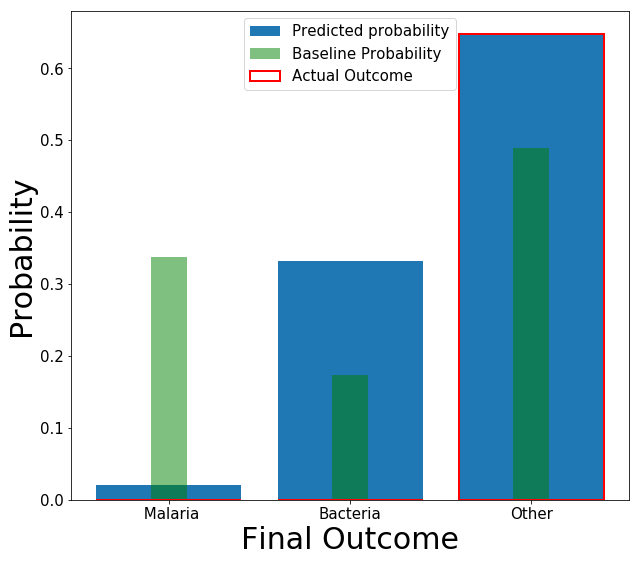

In [600]:
ind = randind[0]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

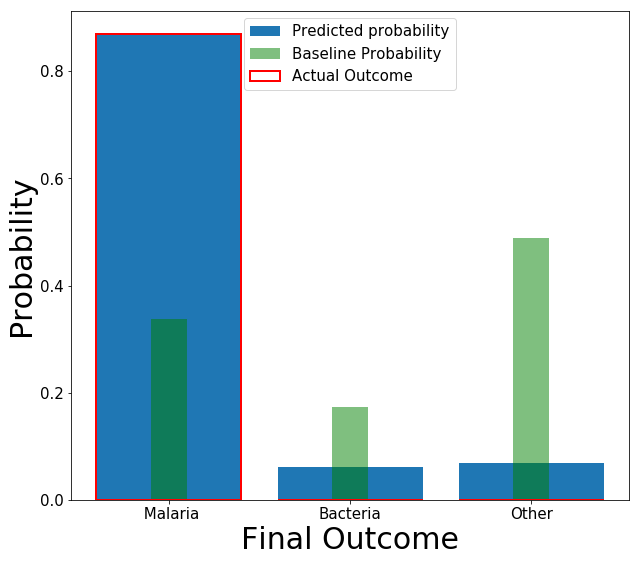

In [601]:
ind = randind[1]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

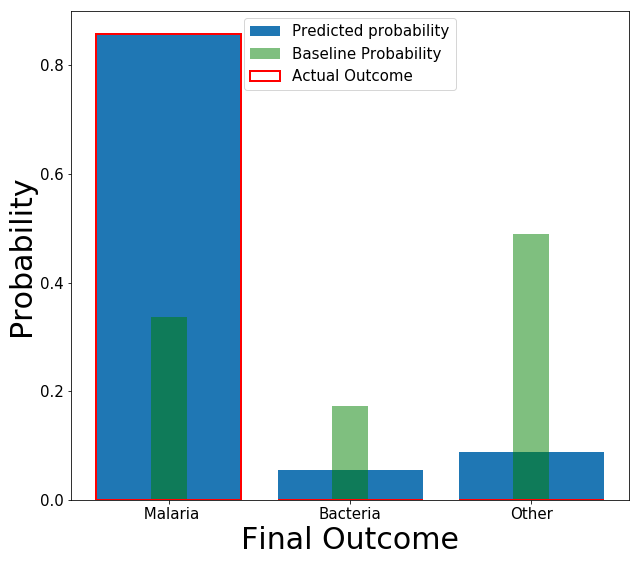

In [602]:
ind = randind[2]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

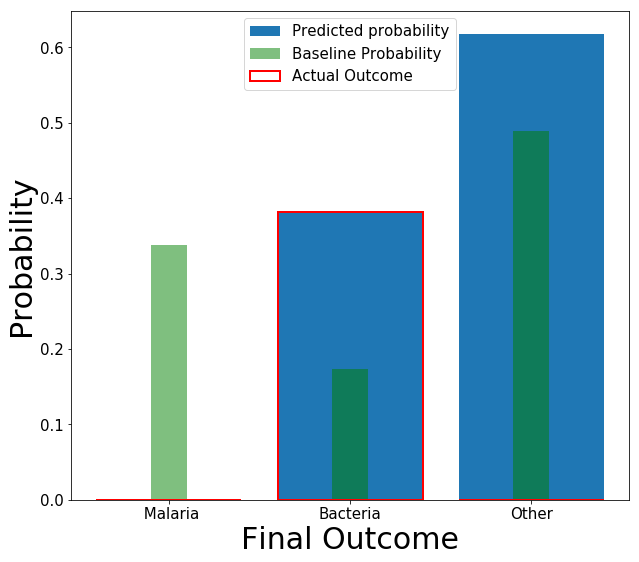

In [603]:
ind = randind[3]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

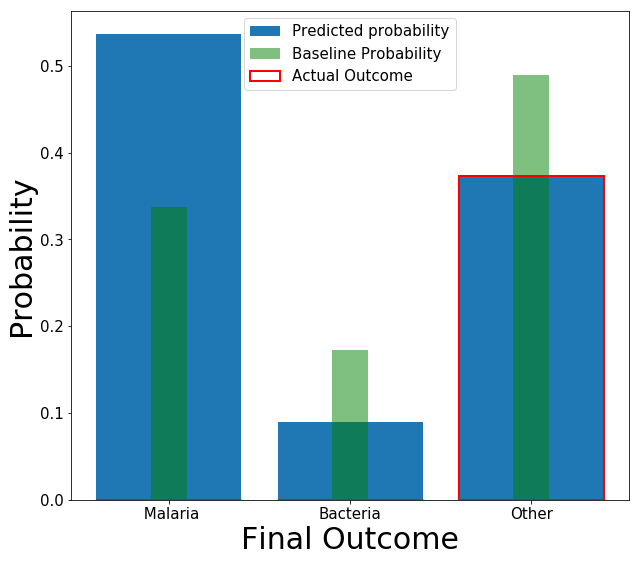

In [604]:
ind = randind[4]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

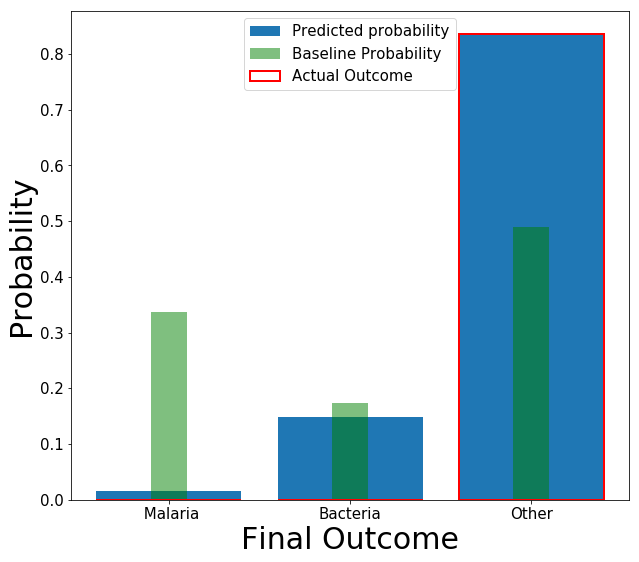

In [605]:
ind = randind[5]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

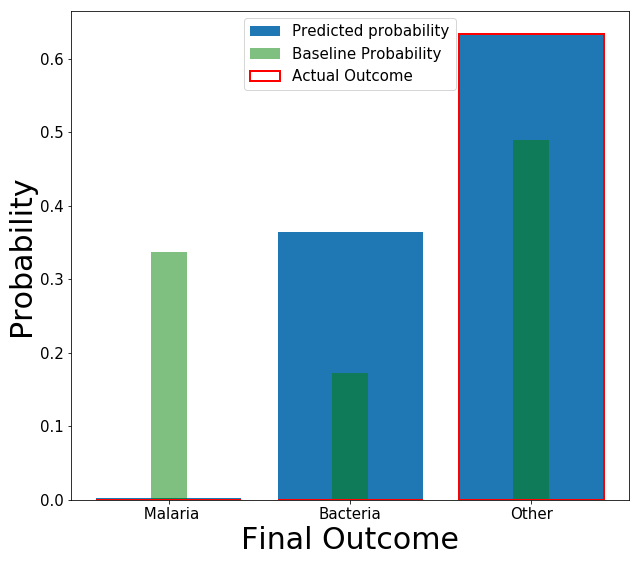

In [606]:
ind = randind[6]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

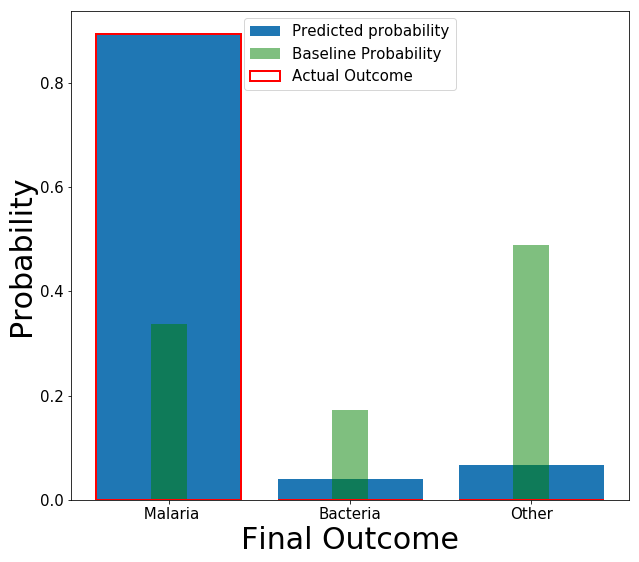

In [607]:
ind = randind[7]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

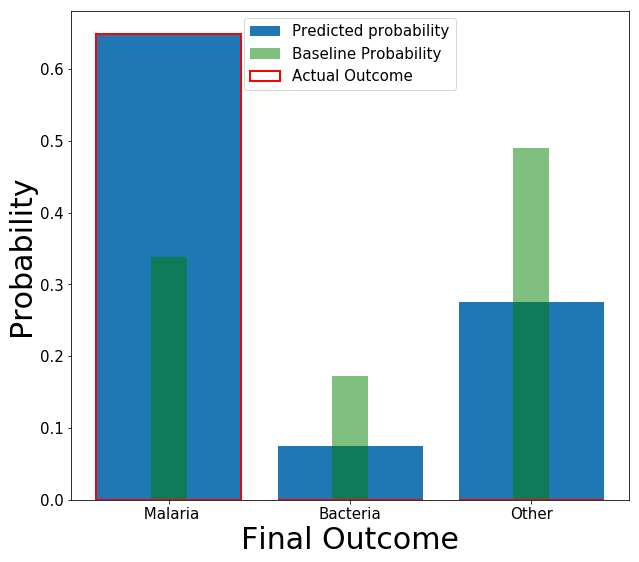

In [608]:
ind = randind[8]
n = len(posterior)
plt.bar([" Malaria","Bacteria","Other"], height=[
    np.asscalar(sum(posterior.values[:,ind] == 0) / n),
    np.asscalar(sum(posterior.values[:,ind] == 1) / n),
    np.asscalar(sum(posterior.values[:,ind] == 2) / n)], width=0.8, label = "Predicted probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[(y[ind] == 0).astype(int)*sum(posterior.values[:,ind] == 0) / n,
                 (y[ind] == 1).astype(int)*sum(posterior.values[:,ind] == 1) / n,
                 (y[ind] == 2).astype(int)*sum(posterior.values[:,ind] == 2) / n], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 9 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

In [556]:
result = pd.DataFrame({'diag':y})
result['p_mal'] = np.sum(posterior.values[:,:] == 0, axis = 0) / n
result['p_bact'] = np.sum(posterior.values[:,:] == 1, axis = 0) / n
result['p_other'] = np.sum(posterior.values[:,:] == 2, axis = 0) / n

In [557]:
p_mal = result['p_mal']
p_bact = result['p_bact']
p_other = result['p_other']
d_mal = (result['diag'] == 0).astype(int)
d_bact = (result['diag'] == 1).astype(int)
d_other = (result['diag'] == 2).astype(int)
BS = (sum(np.square(p_mal - d_mal)) + sum(np.square(p_bact - d_bact)) + sum(np.square(p_other - d_other))) / len(y)
BS

0.3982786625

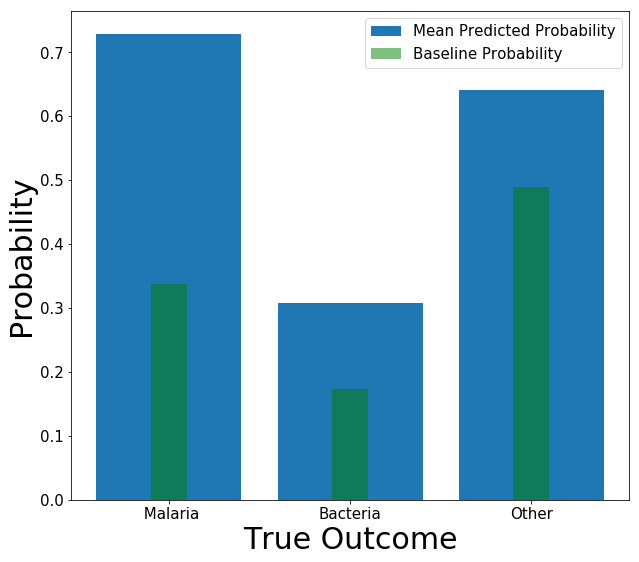

In [614]:
#Average predicted prob of outcome given outcome using posterior
avg_mal_prob = sum(p_mal * d_mal) / sum(d_mal)
avg_bact_prob = sum(p_bact * d_bact) / sum(d_bact)
avg_other_prob = sum(p_other * d_other) / sum(d_other)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')



plt.legend(loc = 1 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

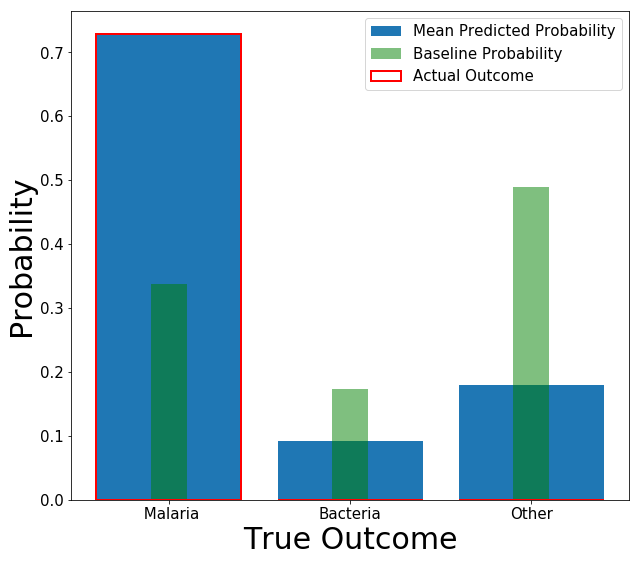

In [615]:
#Average predicted prob of outcome given true malaria
avg_mal_prob = sum(p_mal * d_mal) / sum(d_mal)
avg_bact_prob = sum(p_bact * d_mal) / sum(d_mal)
avg_other_prob = sum(p_other * d_mal) / sum(d_mal)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[avg_mal_prob,
                 0,
                 0], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 1 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

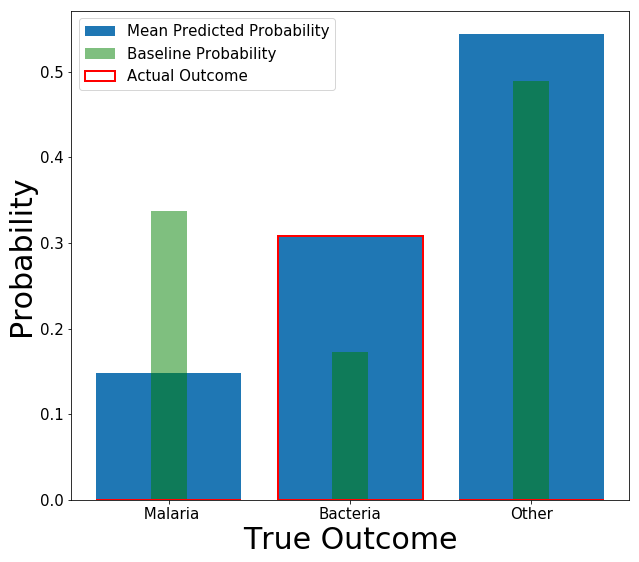

In [620]:
#Average predicted prob of outcome given true bacteria
avg_mal_prob = sum(p_mal * d_bact) / sum(d_bact)
avg_bact_prob = sum(p_bact * d_bact) / sum(d_bact)
avg_other_prob = sum(p_other * d_bact) / sum(d_bact)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[0,
                 avg_bact_prob,
                 0], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 0 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

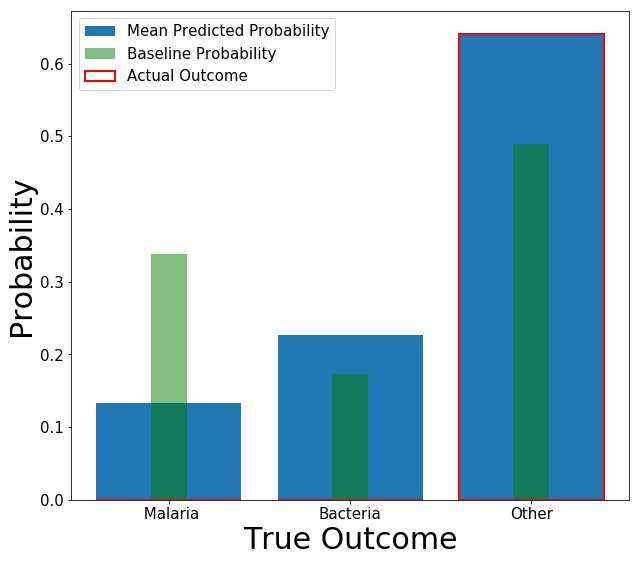

In [621]:
#Average predicted prob of outcome given true neither
avg_mal_prob = sum(p_mal * d_other) / sum(d_other)
avg_bact_prob = sum(p_bact * d_other) / sum(d_other)
avg_other_prob = sum(p_other * d_other) / sum(d_other)

#plot
plt.bar([" Malaria","Bacteria","Other"], height=[
    avg_mal_prob,
    avg_bact_prob,
    avg_other_prob], width=0.8, label = "Mean Predicted Probability")

plt.bar([0,1,2], height =[sum(y == 0) / len(y),sum(y == 1) / len(y),sum(y == 2) / len(y)], 
        width=0.25*0.8, color='g', alpha=0.5, label='Baseline Probability')

plt.bar([0,1,2], 
        height =[0,
                 0,
                 avg_other_prob], 
        width=0.8, edgecolor = 'r',color='b', fc=(0, 1, 0, 0), lw = 2, label="Actual Outcome")

plt.legend(loc = 0 , prop={'size': 15})
plt.ylabel("Probability", fontsize = 30)
plt.xlabel("True Outcome", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)

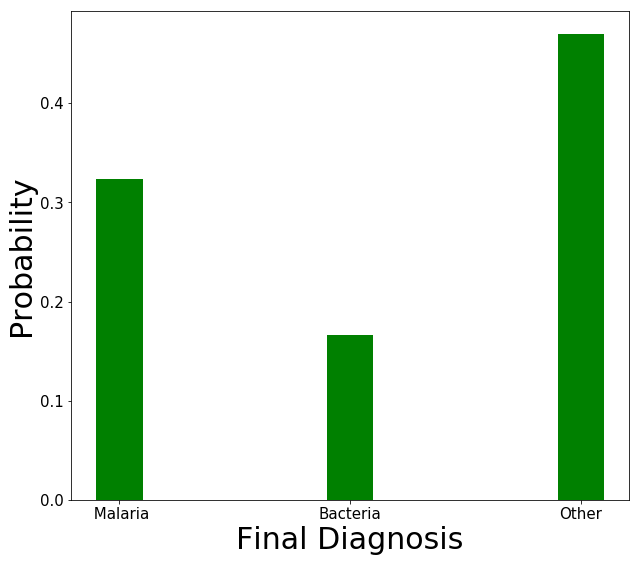

In [500]:
#Baseline prediction

plt.bar([" Malaria","Bacteria","Other"], height=[
    sum(y == 0) / 500,
    sum(y == 1) / 500,
    sum(y == 2) / 500], width=0.25*0.8, color='g')

plt.ylabel("Probability", fontsize = 30)
plt.xlabel("Final Diagnosis", fontsize = 30)
plt.rcParams["figure.figsize"] = (10, 9)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=8)